In [1]:
# Import libraries
import pandas as pd
import yfinance as yf
import numpy as np
import math
from datetime import date, timedelta

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

today = date.today()

Phase 1: Data Collection and Preprocessing

1. Downloading Data

In [2]:
# Set up
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365*4)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [3]:
# "download_data" Function 
def download_data(crypto_name, start_date, end_date):
    data = yf.download(crypto_name, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
    data["Date"] = data.index 
    data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

In [4]:
# Download BTC-USD 
btc_data = download_data("BTC-USD", start_date, end_date)
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-25,7039.977051,7319.856934,6617.166992,7146.133789,7146.133789,42685231262
1,2019-11-26,7145.159180,7320.230469,7098.572266,7218.371094,7218.371094,21129505542
2,2019-11-27,7220.880859,7619.693359,6974.174316,7531.663574,7531.663574,23991412764
3,2019-11-28,7536.820312,7730.072754,7454.121582,7463.105957,7463.105957,19050116751
4,2019-11-29,7466.727051,7781.179688,7460.756348,7761.243652,7761.243652,19709695456


In [5]:
# Download ETH-USD
eth_data = download_data("ETH-USD", start_date, end_date)
eth_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-25,142.697006,150.207962,133.802338,146.476532,146.476532,10962753356
1,2019-11-26,146.404312,150.004761,145.216873,148.965073,148.965073,7648516297
2,2019-11-27,148.396820,154.887207,143.525604,153.010559,153.010559,8778095308
3,2019-11-28,153.069244,156.613586,151.091125,151.717575,151.717575,7346531960
4,2019-11-29,151.768600,156.848404,151.460434,155.304153,155.304153,7503898278


2. Exploratory Data Analyst

In [6]:
# "information" function
def information(data):
    print(data.info())
    print(data.describe())
    print("Has Null values?:", data.isnull().values.any())
    print("Shape:", data.shape)

In [7]:
information(btc_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1460 non-null   datetime64[ns]
 1   Open       1460 non-null   float64       
 2   High       1460 non-null   float64       
 3   Low        1460 non-null   float64       
 4   Close      1460 non-null   float64       
 5   Adj Close  1460 non-null   float64       
 6   Volume     1460 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 80.0 KB
None
                      Date          Open          High           Low  \
count                 1460   1460.000000   1460.000000   1460.000000   
mean   2021-11-23 12:00:00  27993.767387  28635.109336  27301.060874   
min    2019-11-25 00:00:00   5002.578125   5331.833984   4106.980957   
25%    2020-11-23 18:00:00  16441.395996  16636.254883  16162.726318   
50%    2021-11-23 12:00:00  26728.87

In [8]:
information(eth_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1460 non-null   datetime64[ns]
 1   Open       1460 non-null   float64       
 2   High       1460 non-null   float64       
 3   Low        1460 non-null   float64       
 4   Close      1460 non-null   float64       
 5   Adj Close  1460 non-null   float64       
 6   Volume     1460 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 80.0 KB
None
                      Date         Open         High          Low  \
count                 1460  1460.000000  1460.000000  1460.000000   
mean   2021-11-23 12:00:00  1661.932164  1708.848321  1610.275955   
min    2019-11-25 00:00:00   110.406784   116.021622    95.184303   
25%    2020-11-23 18:00:00   533.475464   557.839386   507.153465   
50%    2021-11-23 12:00:00  1645.368896  1672.01092

In [9]:
# "plot" function
def plot(y):
    names = cycle(['Open Price','Close Price','High Price','Low Price'])

    fig = px.line(y, x=y.Date, y=[y['Open'], y['Close'], y['High'], y['Low']],labels={'Date': 'Date','value':'Stock value'})
    fig.update_layout(title_text='Performance Graph', font_size=15, font_color='black',legend_title_text='Stock Parameters')
    fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)

    fig.show()
    return fig

# "high_low_plot" function
def high_low_plot(df, y, new_order):
    monthvise_high = y.groupby(df['Date'].dt.strftime('%B'))['High'].max()
    monthvise_high = monthvise_high.reindex(new_order, axis=0)

    monthvise_low = y.groupby(df['Date'].dt.strftime('%B'))['Low'].min()
    monthvise_low = monthvise_low.reindex(new_order, axis=0)

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x = monthvise_high.index,
        y = monthvise_high,
        name='High Price',
        marker_color='rgb(0, 153, 204)'
    ))
    fig.add_trace(go.Bar(
        x = monthvise_low.index,
        y = monthvise_low,
        name='Low Price',
        marker_color='rgb(255, 128, 0)'
    ))

    fig.update_layout(barmode='group', title=' Monthly High Price and Low Price')
    fig.show()
    return fig

# "open_close_plot" function
def open_close_plot(data):
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x = data.index,
        y = data['Open'],
        name ='Open Price',
        marker_color='crimson'
    ))
    fig.add_trace(go.Bar(
        x=data.index,
        y=data['Close'],
        name='Close Price',
        marker_color='lightsalmon'
    ))

    fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Monthly Open-Close Price Analysis')
    fig.show()
    return fig

In [10]:
# "data_yearly" function
def data_yearly(df, start_year, end_year):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    y = df.loc[(df['Date'] >= f'{str(start_year)}-01-01')
                     & (df['Date'] < f'{str(end_year)}-01-01')]

    y.drop(y[['Adj Close','Volume']],axis=1)

    monthvise= y.groupby(y['Date'].dt.strftime('%B'))[['Open','Close']].mean()
    new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthvise = monthvise.reindex(new_order, axis=0)
    print(monthvise)

    open_close_plot(monthvise)
    high_low_plot(df, y, new_order)
    plot(y)

In [11]:
# "show_data" function
def show_data(data):
    for year in range(2019, 2024):
        print(f"In {year}")
        print(data_yearly(data, year, year + 1))

In [12]:
show_data(btc_data)

In 2019
                  Open        Close
Date                               
January            NaN          NaN
February           NaN          NaN
March              NaN          NaN
April              NaN          NaN
May                NaN          NaN
June               NaN          NaN
July               NaN          NaN
August             NaN          NaN
September          NaN          NaN
October            NaN          NaN
November   7362.270264  7448.357992
December   7296.351626  7284.013042


None
In 2020
                   Open         Close
Date                                 
January     8318.949597   8389.270476
February    9656.215113   9630.722185
March       6943.507009   6871.016113
April       7150.611328   7224.477327
May         9237.761530   9263.151745
June        9499.797005   9489.227214
July        9519.383852   9589.899729
August     11639.097215  11652.394185
September  10689.700163  10660.276855
October    11791.307491  11886.978201
November   16450.121647  16645.757422
December   21680.540827  21983.137097


None
In 2021
                   Open         Close
Date                                 
January    34652.961694  34761.649950
February   45874.967215  46306.798968
March      54544.678175  54998.008695
April      57251.256250  57206.720052
May        47105.828503  46443.286668
June       35920.546940  35845.154687
July       34234.212450  34444.973790
August     45516.119834  45709.022681
September  46041.859375  45939.771484
October    57344.743952  57911.970514
November   60857.520312  60621.488802
December   49670.411794  49263.209173


None
In 2022
                   Open         Close
Date                                 
January    41368.073463  41114.422379
February   40591.103934  40763.474051
March      41889.148438  41966.237525
April      41694.653646  41435.319661
May        31900.711127  31706.105217
June       24783.338477  24383.685482
July       21424.733052  21539.253843
August     22471.866557  22366.266318
September  19821.353711  19804.779232
October    19616.090285  19650.525643
November   17711.480599  17600.814323
December   16969.578818  16949.608808


None
In 2023
                   Open         Close
Date                                 
January    20043.860131  20250.717490
February   23304.086007  23304.539202
March      24945.340411  25116.900895
April      28823.841732  28857.574544
May        27562.723160  27499.307145
June       27651.926758  27763.198437
July       30098.767578  30057.469947
August     27959.756615  27852.792843
September  26271.268229  26306.136393
October    29511.811114  29755.895161
November   36154.175442  36270.967731
December            NaN           NaN


None


In [13]:
show_data(eth_data)

In 2019
                 Open       Close
Date                             
January           NaN         NaN
February          NaN         NaN
March             NaN         NaN
April             NaN         NaN
May               NaN         NaN
June              NaN         NaN
July              NaN         NaN
August            NaN         NaN
September         NaN         NaN
October           NaN         NaN
November   149.603732  151.335597
December   138.784074  138.041703


None
In 2020
                 Open       Close
Date                             
January    155.320138  156.972718
February   237.377253  238.756287
March      163.235093  160.376243
April      169.488213  171.946989
May        207.346755  208.125855
June       236.268403  236.159229
July       255.554494  259.405542
August     399.326147  402.153482
September  370.883198  368.373035
October    375.362575  376.222389
November   478.696689  486.144514
December   618.537283  622.488431


None
In 2021
                  Open        Close
Date                               
January    1184.997553  1202.502802
February   1696.234375  1699.808921
March      1720.526655  1736.862222
April      2269.130294  2297.672754
May        3142.513688  3140.730760
June       2349.590800  2335.792391
July       2122.466194  2131.080362
August     3069.708630  3098.384939
September  3349.545020  3337.052686
October    3776.929798  3818.767996
November   4432.402661  4434.128711
December   4078.955007  4044.742479


None
In 2022
                  Open        Close
Date                               
January    3086.863076  3054.655100
February   2859.761945  2868.178973
March      2864.621740  2876.342340
April      3115.222518  3096.986271
May        2213.557712  2187.318915
June       1411.869230  1382.772276
July       1339.623811  1359.407778
August     1703.347814  1699.230370
September  1491.504883  1484.229456
October    1359.679743  1367.615620
November   1307.122107  1297.930184
December   1240.294394  1237.105890


None
In 2023
                  Open        Close
Date                               
January    1454.913763  1466.950026
February   1623.919765  1624.605630
March      1668.488836  1675.357851
April      1915.151611  1916.934652
May        1845.306196  1845.626378
June       1816.607914  1818.705579
July       1895.858863  1893.345290
August     1763.744975  1756.978157
September  1620.422725  1621.299198
October    1655.714930  1660.023508
November   1958.068699  1968.944267
December           NaN          NaN


None


3. Preprocessing

In [14]:
# "create_dataset" function
def create_dataset(data, time_step):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
# "preprocessing" function
def preprocessing(data):
    # Extract columns
    close_df = data[["Date", "Close"]]
    print("Shape of close dataframe:", close_df.shape)
    
    # Visualize historical performance
    fig = px.line(close_df, x= close_df.Date, y= close_df.Close, labels={'date':'Date','close':'Close Price'})
    fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='pink')
    fig.update_layout(title_text='Historical Price Performance Overview (2019-2023)', plot_bgcolor='white', 
                    font_size=15, font_color='black')
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

    # Filter data
    close_df = close_df[close_df['Date'] > '2022-11-23']
    close_stock = close_df.copy()
    print("Total data for prediction: ",close_df.shape[0])

    # Visualize predictive analysis
    fig = px.line(close_df, x=close_df.Date, y=close_df.Close,labels={'date':'Date','close':'Close Stock'})
    fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
    fig.update_layout(title_text='Predictive Analysis for Future Close Prices', 
                    plot_bgcolor='white', font_size=15, font_color='black')
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    fig.show()

    # Delete 'Date' column and normalize Data
    del close_df['Date']
    scaler=MinMaxScaler(feature_range=(0,1))
    close_df=scaler.fit_transform(np.array(close_df).reshape(-1,1))
    print("Dataset:", close_df.shape)

    # Split dataset into Training and Testing sets
    training_size=int(len(close_df)*0.80)
    test_size=len(close_df)-training_size
    train_data,test_data=close_df[0:training_size,:],close_df[training_size:len(close_df),:1]
    print("train_data: ", train_data.shape)
    print("test_data: ", test_data.shape)
    
    return close_stock, close_df, train_data, test_data, scaler

Phase 2: Model Building and Predicting

1. BTC dataset

In [16]:
# Prepare data
close_stock, close_df, train_data, test_data, scaler = preprocessing(btc_data)
close_stock.to_csv("btc_training_data.csv")

Shape of close dataframe: (1460, 2)


Total data for prediction:  365


Dataset: (365, 1)
train_data:  (292, 1)
test_data:  (73, 1)


In [17]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (290, 1)
y_train:  (290,)
X_test:  (71, 1)
y_test (71,)
X_train:  (290, 1, 1)
X_test:  (71, 1, 1)


In [18]:
# Create LSTM model
model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=80,batch_size=1,verbose=1)

Epoch 1/80
290/290 [==============================] - 2s 2ms/step - loss: 0.0575 - val_loss: 0.0309
Epoch 2/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0149
Epoch 3/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 4/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 5/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 7/80
290/290 [==============================] - 0s 1ms/step - loss: 9.8603e-04 - val_loss: 0.0038
Epoch 8/80
290/290 [==============================] - 0s 1ms/step - loss: 9.4994e-04 - val_loss: 0.0046
Epoch 9/80
290/290 [==============================] - 0s 1ms/step - loss: 9.5392e-04 - val_loss: 0.0032
Epoch 10/80
290/290 [==============================] - 0s 1ms/step - loss: 9.6601e-04 - 

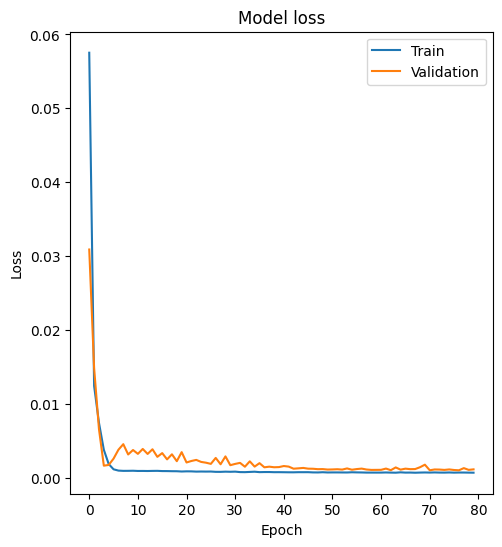

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [20]:
# Make predictions
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 2ms/step


((290, 1), (71, 1))

In [21]:
# Inverse transformation
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [22]:
# Calculate and print explained variance regression scores
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9846903797885722
Test data explained variance regression score: 0.972691999337772


In [23]:
# Calculate and print R2 scores
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9845696500785845
Test data R2 score: 0.9699498230896972


In [24]:
# Predictions plot
look_back = time_step

# Initialize arrays for predicted values
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan

# Fill in the predicted values for the training set
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan

# Fill in the predicted values for the testing set
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(close_df) - 1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

# Create a DataFrame for plotting
plotdf = pd.DataFrame({
    'date': close_stock['Date'],
    'original_close': close_stock['Close'],
    'train_predicted_close': trainPredictPlot.reshape(1, -1)[0].tolist(),
    'test_predicted_close': testPredictPlot.reshape(1, -1)[0].tolist()
})

# Plotting using Plotly Express
fig = px.line(plotdf, x=plotdf['date'], y=[plotdf['original_close'], plotdf['train_predicted_close'],
                                           plotdf['test_predicted_close']],
              labels={'value': 'Stock price', 'date': 'Date'})
fig.update_layout(
    title_text='Close Price Disparity Evaluation',
    plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price'
)

# Update trace names for better visualization
names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])
fig.for_each_trace(lambda t: t.update(name=next(names)))

# Update layout to remove gridlines
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()


Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


In [25]:
# Prepare input dataset
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30

while i < pred_days:
    
    if len(temp_input) > time_step:
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i + 1
        
    else:
        
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i = i + 1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [26]:
# Concatenate original and predicted data
lstmdf = np.concatenate([close_df, np.array(lst_output).reshape(-1, 1)])

# Inverse transform to the original scale
lstmdf = scaler.inverse_transform(lstmdf)

# Flatten the array
lstmdf = lstmdf.flatten()

# Create a DataFrame with the same index as close_df
plot_df = pd.DataFrame(lstmdf, index=np.arange(len(lstmdf)), columns=['Close'])

# Plotting
fig = px.line(x=plot_df.index, y=plot_df['Close'], labels={'y': 'Stock price', 'x': 'Timestamp'})
fig.update_layout(title_text='Actual vs Predicted Closing Price Chart',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Stock')

# Add original and predicted close prices to the legend
names = cycle(['Original close price', 'Predicted close price'])
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [27]:
model.save("btc_lstm.h5")

2. ETH dataset

In [28]:
# Prepare data
close_stock, close_df, train_data, test_data, scaler = preprocessing(eth_data)
close_stock.to_csv("eth_training_data.csv")

Shape of close dataframe: (1460, 2)


Total data for prediction:  365


Dataset: (365, 1)
train_data:  (292, 1)
test_data:  (73, 1)


In [29]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
# Display the shape
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

# Reshape input for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (290, 1)
y_train:  (290,)
X_test:  (71, 1)
y_test (71,)
X_train:  (290, 1, 1)
X_test:  (71, 1, 1)


In [30]:
# Create a Sequential Model
model=Sequential()
# Add an LSTM Layer
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
# Add a Dense Output Layer
model.add(Dense(1))
# Compile the Model
model.compile(loss="mean_squared_error",optimizer="adam")

# Train the Model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=80,batch_size=1,verbose=1)

Epoch 1/80
290/290 [==============================] - 1s 2ms/step - loss: 0.1261 - val_loss: 0.0189
Epoch 2/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0091
Epoch 3/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0060
Epoch 4/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0042
Epoch 5/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 6/80
290/290 [==============================] - 0s 978us/step - loss: 0.0040 - val_loss: 0.0027
Epoch 7/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 10/80
290/290 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.00

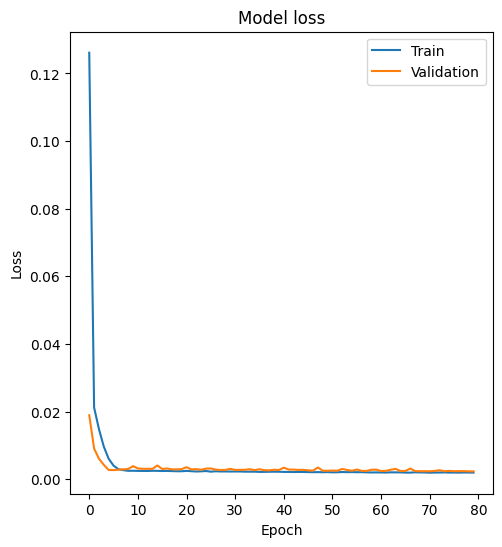

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [32]:
# Make predictions
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 1ms/step


((290, 1), (71, 1))

In [33]:
# Inverse transformation
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [34]:
# Calculate and print explained variance regression scores
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9691209956327952
Test data explained variance regression score: 0.9265540921618313


In [35]:
# Calculate and print R2 scores
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9685335459279051
Test data R2 score: 0.9265075731088035


In [36]:
# Predictions plot
look_back = time_step

# Initialize arrays for predicted values
trainPredictPlot = np.empty_like(close_df)
trainPredictPlot[:, :] = np.nan

# Fill in the predicted values for the training set
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# Shift test predictions for plotting
testPredictPlot = np.empty_like(close_df)
testPredictPlot[:, :] = np.nan

# Fill in the predicted values for the testing set
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(close_df) - 1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

# Create a DataFrame for plotting
plotdf = pd.DataFrame({
    'date': close_stock['Date'],
    'original_close': close_stock['Close'],
    'train_predicted_close': trainPredictPlot.reshape(1, -1)[0].tolist(),
    'test_predicted_close': testPredictPlot.reshape(1, -1)[0].tolist()
})

# Plotting using Plotly Express
fig = px.line(plotdf, x=plotdf['date'], y=[plotdf['original_close'], plotdf['train_predicted_close'],
                                           plotdf['test_predicted_close']],
              labels={'value': 'Stock price', 'date': 'Date'})
fig.update_layout(
    title_text='Close Price Disparity Evaluation',
    plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price'
)

# Update trace names for better visualization
names = cycle(['Original close price', 'Train predicted close price', 'Test predicted close price'])
fig.for_each_trace(lambda t: t.update(name=next(names)))

# Update layout to remove gridlines
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


In [37]:
# Prepare input dataset
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30

while i < pred_days:
    
    if len(temp_input) > time_step:
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i + 1
        
    else:
        
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i = i + 1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [38]:
# Concatenate original and predicted data
lstmdf = np.concatenate([close_df, np.array(lst_output).reshape(-1, 1)])

# Inverse transform to the original scale
lstmdf = scaler.inverse_transform(lstmdf)

# Flatten the array
lstmdf = lstmdf.flatten()

# Create a DataFrame with the same index as close_df
plot_df = pd.DataFrame(lstmdf, index=np.arange(len(lstmdf)), columns=['Close'])

# Plotting
fig = px.line(x=plot_df.index, y=plot_df['Close'], labels={'y': 'Stock price', 'x': 'Timestamp'})
fig.update_layout(title_text='Actual vs Predicted Closing Price Chart',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Stock')

# Add original and predicted close prices to the legend
names = cycle(['Original close price', 'Predicted close price'])
fig.for_each_trace(lambda t: t.update(name=next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [39]:
model.save("eth_lstm.h5")